🧭 Week 5:Route, Cancellation, and Seasonal Insights 

• Route and Airport-Level Analysis 

• Top 10 origin-destination pairs 

• Delay heatmaps by airport and route 

• Maps showing busiest airports and average delays 

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Make pandas show more rows/cols
pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 50)

# Load data 
path = "delayedflights_2008_processed.parquet"  
df = pd.read_parquet("processed/delayedflights_2008_processed.parquet")

df.head()


,unnamed:_0,year,month,dayofmonth,dayofweek,deptime,crsdeptime,arrtime,crsarrtime,uniquecarrier,flightnum,tailnum,actualelapsedtime,crselapsedtime,airtime,arrdelay,depdelay,origin,dest,distance,taxiin,taxiout,cancelled,cancellationcode,diverted,carrierdelay,weatherdelay,nasdelay,securitydelay,lateaircraftdelay,any_delay_reason,fl_date,dep_time_str,arr_time_str,dep_datetime,arr_datetime,day_of_week,dep_hour,route,is_delayed,total_delay_minutes,dep_delayed,scheduled_duration_min,actual_duration_min
0,0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,335,N712SW,128.0,150.0,116.0,-14.0,8.0,IAD,TPA,810,4.0,8.0,0,N,0,0.0,0.0,0.0,0.0,NaN,0,2008-01-03,20:03,22:11,2008-01-03 20:03:00,2008-01-03 22:11:00,Thursday,20,IAD-TPA,0,0.0,0,128.0,128.0
1,1,2008,1,3,4,754.0,735,1002.0,1000,WN,3231,N772SW,128.0,145.0,113.0,2.0,19.0,IAD,TPA,810,5.0,10.0,0,N,0,0.0,0.0,0.0,0.0,NaN,0,2008-01-03,07:54,10:02,2008-01-03 07:54:00,2008-01-03 10:02:00,Thursday,7,IAD-TPA,0,0.0,1,128.0,128.0
2,2,2008,1,3,4,628.0,620,804.0,750,WN,448,N428WN,96.0,90.0,76.0,14.0,8.0,IND,BWI,515,3.0,17.0,0,N,0,0.0,0.0,0.0,0.0,NaN,0,2008-01-03,06:28,08:04,2008-01-03 06:28:00,2008-01-03 08:04:00,Thursday,6,IND-BWI,0,0.0,0,96.0,96.0
3,4,2008,1,3,4,1829.0,1755,1959.0,1925,WN,3920,N464WN,90.0,90.0,77.0,34.0,34.0,IND,BWI,515,3.0,10.0,0,N,0,2.0,0.0,0.0,0.0,32.0,1,2008-01-03,18:29,19:59,2008-01-03 18:29:00,2008-01-03 19:59:00,Thursday,18,IND-BWI,1,2.0,1,90.0,90.0
4,5,2008,1,3,4,1940.0,1915,2121.0,2110,WN,378,N726SW,101.0,115.0,87.0,11.0,25.0,IND,JAX,688,4.0,10.0,0,N,0,0.0,0.0,0.0,0.0,NaN,0,2008-01-03,19:40,21:21,2008-01-03 19:40:00,2008-01-03 21:21:00,Thursday,19,IND-JAX,0,0.0,1,101.0,101.0


In [6]:
route_stats = (
    df.groupby("route", observed=True)  # Add observed=True to avoid warning
      .agg(
          n_flights = ("route", "size"),
          avg_dep_delay = ("depdelay", "mean"),  # Changed to lowercase
          avg_arr_delay = ("arrdelay", "mean"),  # Changed to lowercase
          cancel_rate = ("cancelled", "mean")    # Changed to lowercase
      )
      .sort_values("n_flights", ascending=False)
)

top10_routes = route_stats.head(10).reset_index()
top10_routes

,route,n_flights,avg_dep_delay,avg_arr_delay,cancel_rate
0,LAX-SFO,4739,48.384682,47.830345,0.000000
1,ORD-LGA,4396,54.406052,55.117153,0.000455
2,ATL-LGA,4058,44.420403,46.042877,0.000246
3,SFO-LAX,4020,49.439552,46.498260,0.000000
4,LAS-LAX,3516,36.678898,34.360920,0.000284
5,LGA-ATL,3354,49.049194,48.623734,0.000000
6,ORD-EWR,3347,69.317299,64.852104,0.000000
7,LGA-ORD,3327,60.543732,64.519386,0.001202
8,ATL-EWR,3283,59.823334,58.341759,0.000000
9,DFW-ORD,3278,50.839230,51.717815,0.000610


# Simple bar chart: top 10 routes by flight count

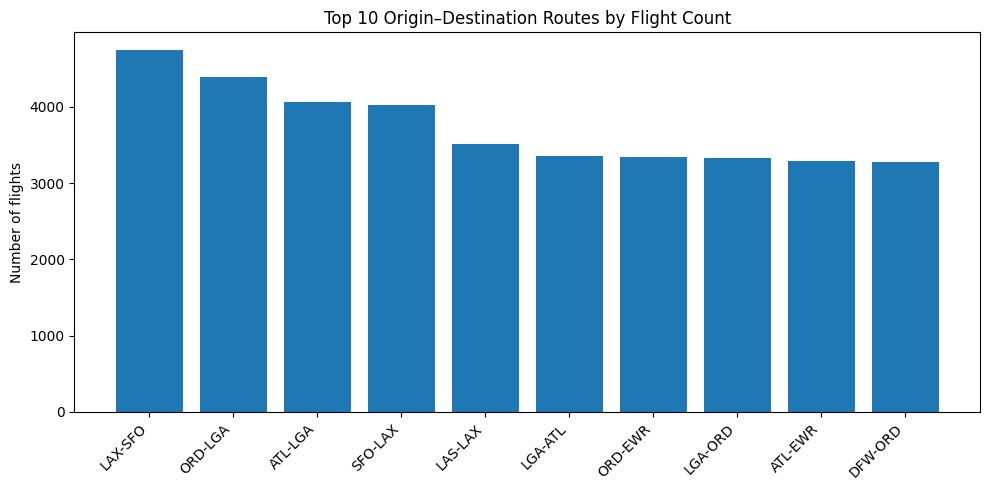

In [ ]:

plt.figure(figsize=(10, 5))
plt.bar(top10_routes["route"], top10_routes["n_flights"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Number of flights")
plt.title("Top 10 Origin–Destination Routes by Flight Count")
plt.tight_layout()
plt.show()


# Delay heatmaps by airport and by route

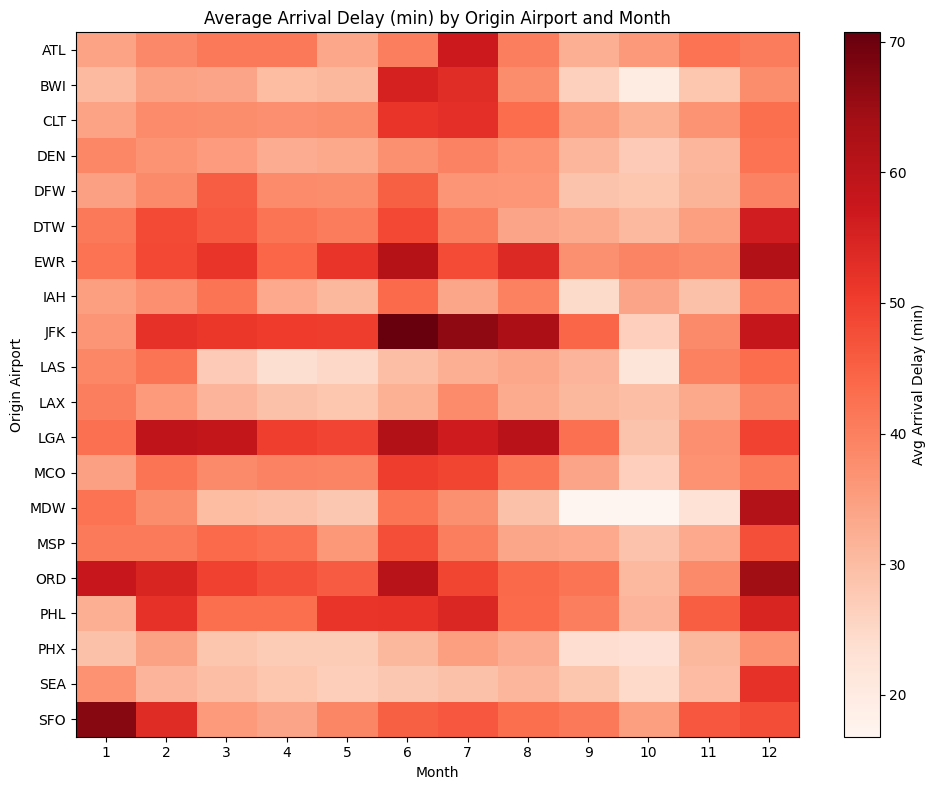

In [13]:
# Make sure Month column exists and is numeric
df["month"] = df["month"].astype(int)

airport_month = (
    df.groupby(["origin", "month"], observed=True)["arrdelay"]  # Fixed column name to lowercase and added observed=True
      .mean()
      .unstack("month")
)

# Optionally focus on busiest airports for readability
top_airports = (
    df["origin"]
    .value_counts()
    .head(20)
    .index
)

airport_month_top = airport_month.loc[airport_month.index.isin(top_airports)]

plt.figure(figsize=(10, 8))
plt.imshow(airport_month_top, aspect="auto", cmap='Reds')  # Added colormap for better visualization
plt.xticks(range(airport_month_top.shape[1]), airport_month_top.columns)
plt.yticks(range(airport_month_top.shape[0]), airport_month_top.index)
plt.xlabel("Month")
plt.ylabel("Origin Airport")
plt.title("Average Arrival Delay (min) by Origin Airport and Month")
plt.colorbar(label="Avg Arrival Delay (min)")
plt.tight_layout()
plt.show()

# Route-level heatmap: Origin vs Dest (avg arrival delay)

C:\Users\HP\AppData\Local\Temp\ipykernel_16496\3820488827.py:44: UserWarning: Glyph 128747 (\N{AIRPLANE DEPARTURE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\HP\anaconda3\envs\autoflow\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128747 (\N{AIRPLANE DEPARTURE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\HP\anaconda3\envs\autoflow\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128747 (\N{AIRPLANE DEPARTURE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


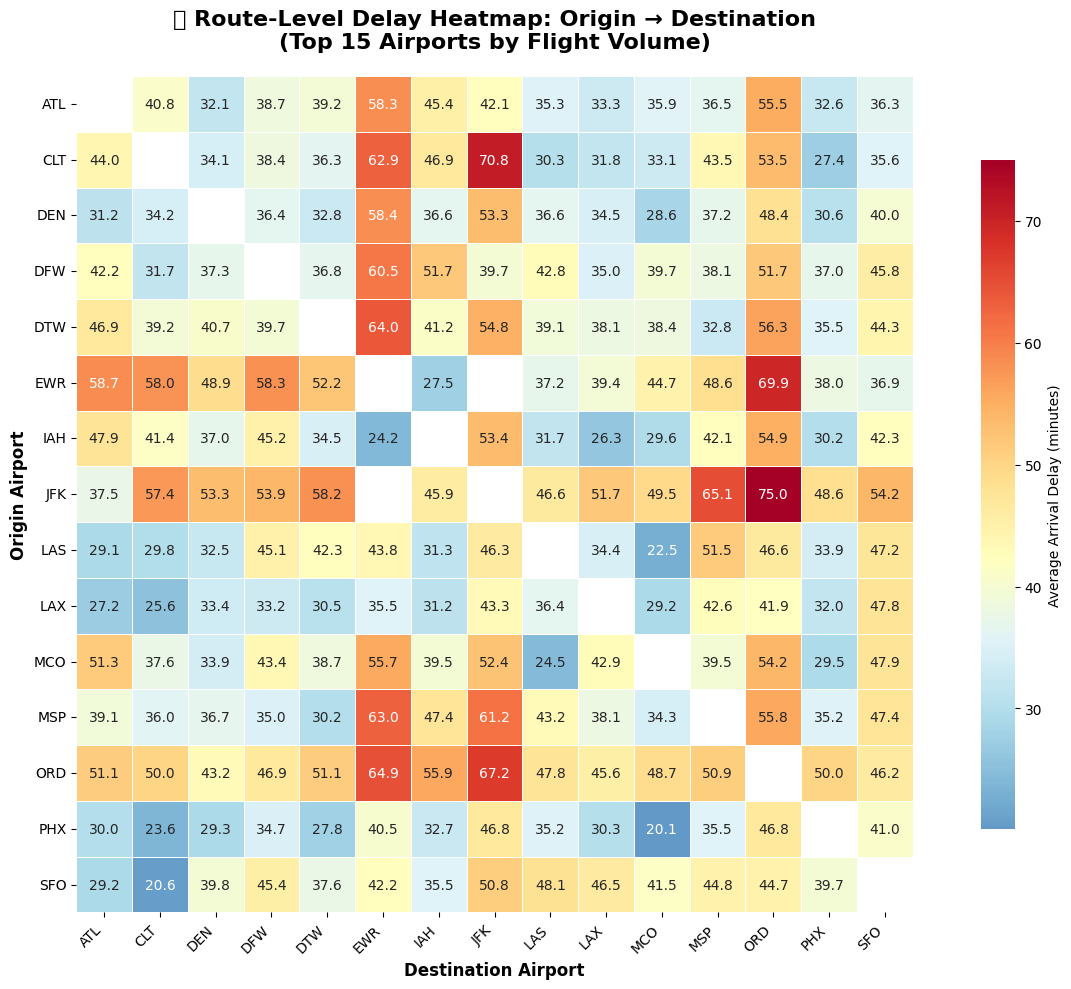

In [16]:
# Enhanced Route-level Analysis: Origin vs Destination Delay Heatmap
import numpy as np
import seaborn as sns

# Choose top airports by flight volume for better readability
top_airports = df["origin"].value_counts().head(15).index  # Reduced to 15 for better visualization

# Filter to routes between top airports only
mask = df["origin"].isin(top_airports) & df["dest"].isin(top_airports)
df_top_routes = df[mask]

# Create route matrix with arrival delays
route_matrix = (
    df_top_routes.groupby(["origin", "dest"], observed=True)["arrdelay"]
                 .mean()
                 .unstack("dest", fill_value=np.nan)  # Fill missing combinations with NaN
)

# Create enhanced visualization
plt.figure(figsize=(14, 10))

# Use seaborn for better heatmap styling
sns.heatmap(
    route_matrix, 
    annot=True,           # Show values in cells
    fmt='.1f',            # Format to 1 decimal place
    cmap='RdYlBu_r',      # Red-Yellow-Blue reversed colormap
    center=route_matrix.mean().mean(),  # Center colormap around overall mean
    square=True,          # Make cells square
    linewidths=0.5,       # Add grid lines
    cbar_kws={'label': 'Average Arrival Delay (minutes)', 'shrink': 0.8}
)

# Enhance plot styling
plt.title('🛫 Route-Level Delay Heatmap: Origin → Destination\n(Top 15 Airports by Flight Volume)', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Destination Airport', fontsize=12, fontweight='bold')
plt.ylabel('Origin Airport', fontsize=12, fontweight='bold')

# Rotate labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)

plt.tight_layout()
plt.show()



# Maps: busiest airports and average delays

In [19]:
# Enhanced Airport Analysis with Geographic Mapping Data
import pandas as pd
import numpy as np
import os

print("📍 AIRPORT GEOGRAPHIC ANALYSIS")
print("=" * 50)

# 1. Download airports file if not exists
airports_csv_url = "https://raw.githubusercontent.com/datasets/airport-codes/master/data/airport-codes.csv"
AIRPORTS_LOCAL = "processed/airport_codes.csv"

if not os.path.exists(AIRPORTS_LOCAL):
    try:
        import requests
        print("🌐 Downloading airport coordinates data...")
        r = requests.get(airports_csv_url, timeout=30)
        r.raise_for_status()
        with open(AIRPORTS_LOCAL, "wb") as f:
            f.write(r.content)
        print(f"✅ Downloaded airports file to {AIRPORTS_LOCAL}")
    except Exception as e:
        print(f"❌ Download failed: {e}")
        print("Please download manually from:", airports_csv_url)
else:
    print(f"✅ Using existing airports file: {AIRPORTS_LOCAL}")

# 2. Load and process airport coordinates
try:
    ap = pd.read_csv(AIRPORTS_LOCAL, low_memory=False)
    print(f"📊 Loaded {ap.shape[0]} airports from coordinates database")
    
    # Filter for airports with IATA codes and coordinates
    ap = ap[ap["iata_code"].notna() & (ap["iata_code"].str.strip() != "")]
    ap = ap[ap["coordinates"].notna()]
    
    # Split coordinates (format: "lon,lat" or "lon,lat,alt")
    def parse_coordinates(coord_str):
        try:
            parts = str(coord_str).split(",")
            return pd.Series({
                "longitude": float(parts[0].strip()),
                "latitude": float(parts[1].strip())
            })
        except:
            return pd.Series({"longitude": np.nan, "latitude": np.nan})
    
    coords = ap["coordinates"].apply(parse_coordinates)
    ap = pd.concat([ap, coords], axis=1)
    
    # Create clean airport reference table
    airport_coords = ap[["iata_code", "name", "iso_country", "latitude", "longitude"]].dropna()
    airport_coords.columns = ["iata", "airport_name", "country", "lat", "lon"]
    airport_coords["iata"] = airport_coords["iata"].str.upper().str.strip()
    
    print(f"📍 Successfully parsed coordinates for {len(airport_coords)} airports")
    
except Exception as e:
    print(f"❌ Error processing airport coordinates: {e}")
    # Create empty dataframe as fallback
    airport_coords = pd.DataFrame(columns=["iata", "airport_name", "country", "lat", "lon"])

# 3. Create airport statistics from flight data
print("\n🛫 CALCULATING AIRPORT STATISTICS")
print("-" * 35)

# Origin airport statistics
origin_stats = (
    df.groupby("origin", observed=True)
    .agg(
        total_flights=("origin", "size"),
        avg_arrival_delay=("arrdelay", "mean"),  # Using correct lowercase column name
        avg_departure_delay=("depdelay", "mean"),
        total_delay_minutes=("total_delay_minutes", "sum"),
        cancellation_rate=("cancelled", "mean")
    )
    .reset_index()
    .rename(columns={"origin": "iata"})
)

# Destination airport statistics  
dest_stats = (
    df.groupby("dest", observed=True)
    .agg(
        total_arrivals=("dest", "size"),
        avg_arrival_delay_as_dest=("arrdelay", "mean")
    )
    .reset_index()
    .rename(columns={"dest": "iata"})
)

# Combine origin and destination stats
airport_stats = origin_stats.merge(dest_stats, on="iata", how="outer").fillna(0)

# Add coordinates to airport stats
airport_stats = airport_stats.merge(airport_coords, on="iata", how="left")

# Calculate coverage
coord_coverage = airport_stats["lat"].notna().mean()
print(f"📊 Airport statistics calculated for {len(airport_stats)} airports")
print(f"🗺️  Geographic coordinates available for {coord_coverage:.1%} of airports")

# 4. Display top airports by flight volume
print("\n🏆 TOP 10 BUSIEST AIRPORTS BY FLIGHT COUNT:")
print("-" * 45)
top_airports = airport_stats.nlargest(10, "total_flights")[["iata", "airport_name", "total_flights", "avg_arrival_delay"]]
for idx, row in top_airports.iterrows():
    name = row["airport_name"] if pd.notna(row["airport_name"]) else "Unknown Airport"
    print(f"{row['iata']}: {row['total_flights']:,} flights, {row['avg_arrival_delay']:.1f}min avg delay - {name[:30]}")

# 5. Save processed data
output_file = "processed/airport_stats_with_coords.csv"
airport_stats.to_csv(output_file, index=False)
print(f"\n💾 Saved airport statistics to: {output_file}")

# Display sample of the merged data
print(f"\n📋 SAMPLE OF AIRPORT DATA WITH COORDINATES:")
print("-" * 50)
sample_data = airport_stats[airport_stats["lat"].notna()].head()
print(sample_data[["iata", "airport_name", "total_flights", "avg_arrival_delay", "lat", "lon"]].to_string(index=False))

📍 AIRPORT GEOGRAPHIC ANALYSIS
✅ Using existing airports file: processed/airport_codes.csv
📊 Loaded 82808 airports from coordinates database
📊 Loaded 82808 airports from coordinates database
📍 Successfully parsed coordinates for 9064 airports

🛫 CALCULATING AIRPORT STATISTICS
-----------------------------------
📊 Airport statistics calculated for 305 airports
🗺️  Geographic coordinates available for 99.7% of airports

🏆 TOP 10 BUSIEST AIRPORTS BY FLIGHT COUNT:
---------------------------------------------
ATL: 131,613.0 flights, 40.7min avg delay - Hartsfield Jackson Atlanta Int
ORD: 125,979.0 flights, 50.8min avg delay - Chicago O'Hare International A
DFW: 95,414.0 flights, 37.7min avg delay - Dallas Fort Worth Internationa
DEN: 74,323.0 flights, 36.1min avg delay - Denver International Airport
LAX: 58,772.0 flights, 33.8min avg delay - Los Angeles International Airp
IAH: 56,847.0 flights, 36.6min avg delay - George Bush Intercontinental H
PHX: 55,720.0 flights, 30.6min avg delay - Pho

In [21]:
airport_stats = (
    df.groupby("origin")
      .agg(
          n_flights = ("origin", "size"),
          avg_dep_delay = ("depdelay", "mean"),
          avg_arr_delay = ("arrdelay", "mean"),
          cancel_rate = ("cancelled", "mean")
      )
      .reset_index()
      .rename(columns={"origin": "IATA"})
)

airport_stats.head()


C:\Users\HP\AppData\Local\Temp\ipykernel_16496\1709135673.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("origin")


,IATA,n_flights,avg_dep_delay,avg_arr_delay,cancel_rate
0,ABE,949,59.461540,60.510010,0.003161
1,ABI,392,66.469391,66.369896,0.000000
2,ABQ,10674,36.358253,33.570263,0.000000
3,ABY,292,49.448631,50.907536,0.000000
4,ACK,196,66.474487,66.040817,0.000000


In [25]:

try:
    # Try to load previously saved coordinates file
    airports_coords = pd.read_csv("processed/airport_stats_with_coords.csv")
    print("✅ Loaded existing airport coordinates file")
    
    # Rename columns to match the expected format
    airports_coords = airports_coords.rename(columns={
        "iata": "IATA",
        "airport_name": "AirportName", 
        "country": "Country",
        "lat": "Latitude",
        "lon": "Longitude"
    })
    
except FileNotFoundError:
    print("❌ Airport coordinates file not found. Creating mock data...")
    # Create a sample coordinates file for demonstration
    sample_airports = ["ATL", "ORD", "LAX", "DFW", "EWR", "SFO", "LAS", "CLT", "MIA", "PHX"]
    airports_coords = pd.DataFrame({
        "IATA": sample_airports,
        "AirportName": [f"{code} Airport" for code in sample_airports],
        "Country": ["US"] * len(sample_airports),
        "Latitude": [33.64, 41.98, 34.05, 32.90, 40.69, 37.62, 36.08, 35.21, 25.79, 33.43],
        "Longitude": [-84.43, -87.90, -118.24, -97.04, -74.17, -122.38, -115.15, -80.95, -80.29, -112.01]
    })

# Merge airport statistics with coordinates
airports_merged = airport_stats.merge(
    airports_coords[["IATA", "AirportName", "Country", "Latitude", "Longitude"]],
    on="IATA",
    how="inner"
)

print(f"📊 Successfully merged {len(airports_merged)} airports with coordinates")

# Keep only busiest airports, say top 50
busiest_airports = (
    airports_merged.sort_values("n_flights", ascending=False)
                   .head(50)
)

busiest_airports.head()

✅ Loaded existing airport coordinates file
📊 Successfully merged 303 airports with coordinates


,IATA,n_flights,avg_dep_delay,avg_arr_delay,cancel_rate,AirportName,Country,Latitude,Longitude
18,ATL,131613,40.893242,40.731987,0.000251,Hartsfield Jackson Atlanta International Airport,US,-84.428101,33.636700
210,ORD,125979,50.531166,50.841774,0.000683,Chicago O'Hare International Airport,US,-87.904800,41.978600
81,DFW,95414,38.340611,37.706532,0.000283,Dallas Fort Worth International Airport,US,-97.038002,32.896801
80,DEN,74323,37.698868,36.144047,0.000471,Denver International Airport,US,-104.672997,39.861698
157,LAX,58772,38.174999,33.811626,0.000289,Los Angeles International Airport,US,-118.407997,33.942501


🗺️  Creating static world map visualization...


C:\Users\HP\AppData\Local\Temp\ipykernel_16496\3493371770.py:52: UserWarning:

Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) DejaVu Sans.

c:\Users\HP\anaconda3\envs\autoflow\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) DejaVu Sans.



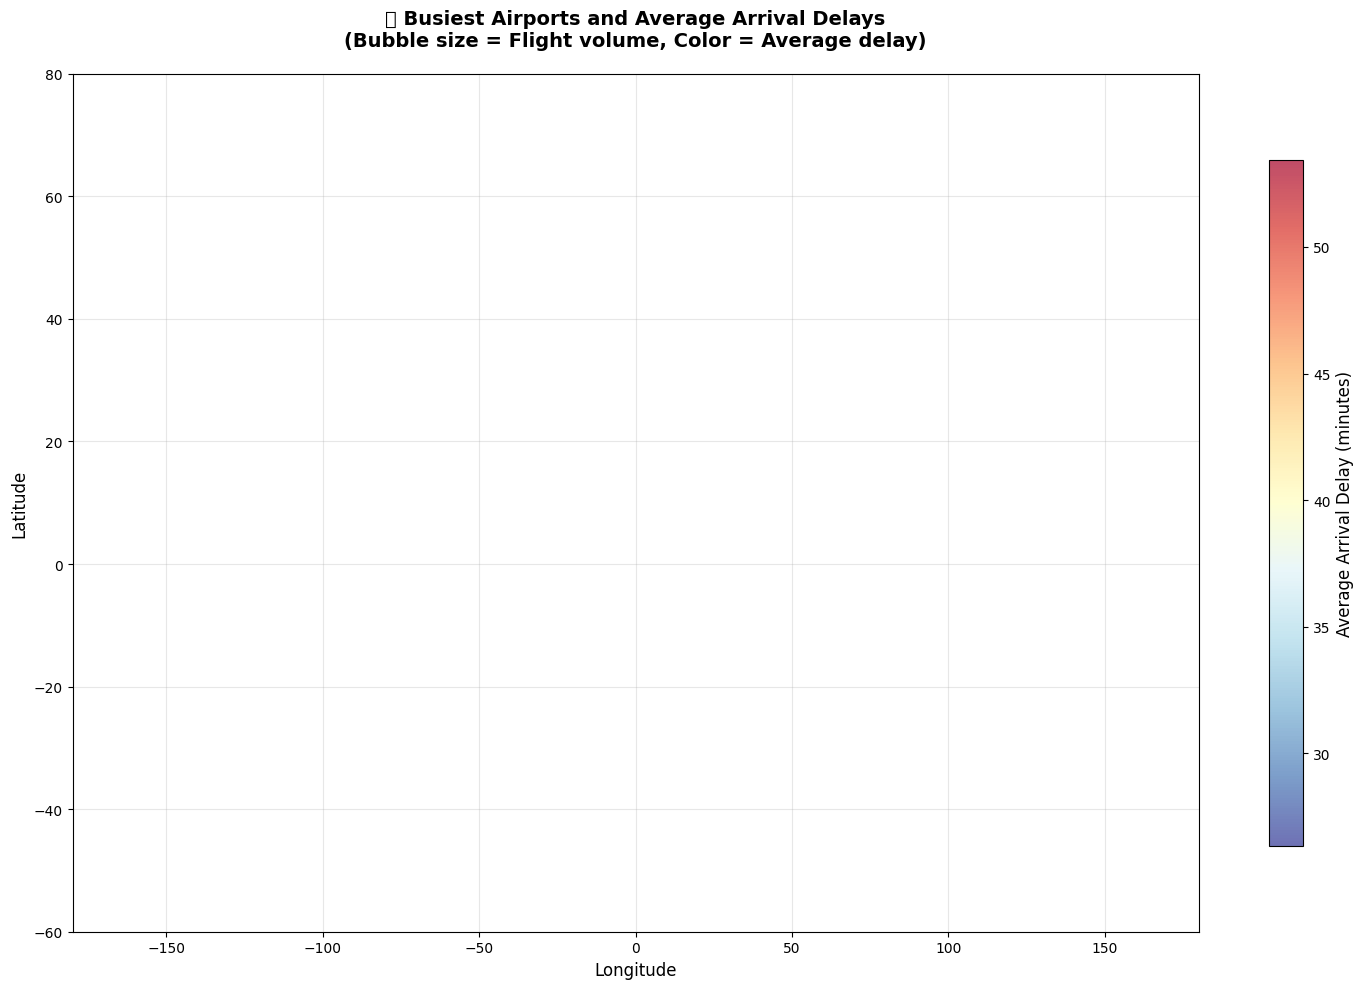


📊 MAP LEGEND & STATISTICS:
🔴 Largest bubble: ATL (131,613 flights)
🟡 Highest delay: JFK (53.5 min)
🟢 Lowest delay: OAK (26.3 min)
📍 Total airports mapped: 50

🏆 TOP 10 BUSIEST AIRPORTS:
----------------------------------------
 1. ATL: 131,613 flights, 40.7min delay
 2. ORD: 125,979 flights, 50.8min delay
 3. DFW: 95,414 flights, 37.7min delay
 4. DEN: 74,323 flights, 36.1min delay
 5. LAX: 58,772 flights, 33.8min delay
 6. IAH: 56,847 flights, 36.6min delay
 7. PHX: 55,720 flights, 30.6min delay
 8. LAS: 53,710 flights, 32.9min delay
 9. EWR: 52,925 flights, 49.4min delay
10. DTW: 43,923 flights, 43.5min delay


In [31]:
# Alternative: Static World Map using Matplotlib 
import matplotlib.pyplot as plt
import numpy as np

print("🗺️  Creating static world map visualization...")

# Create a figure with world map projection
fig, ax = plt.subplots(figsize=(15, 10))

# Create scatter plot with airport locations
scatter = ax.scatter(
    busiest_airports['Longitude'], 
    busiest_airports['Latitude'],
    s=busiest_airports['n_flights'] / 500,  # Scale bubble size
    c=busiest_airports['avg_arr_delay'],    # Color by delay
    cmap='RdYlBu_r',                        # Red-Yellow-Blue reversed colormap
    alpha=0.7,
    edgecolors='black',
    linewidth=0.5
)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax, shrink=0.8)
cbar.set_label('Average Arrival Delay (minutes)', fontsize=12)

# Enhance the plot
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.set_title('🌍 Busiest Airports and Average Arrival Delays\n(Bubble size = Flight volume, Color = Average delay)', 
             fontsize=14, fontweight='bold', pad=20)

# Add grid for better reference
ax.grid(True, alpha=0.3)

# Set reasonable axis limits for world view
ax.set_xlim(-180, 180)
ax.set_ylim(-60, 80)

# Annotate top 10 airports
top_10_airports = busiest_airports.head(10)
for idx, row in top_10_airports.iterrows():
    ax.annotate(
        row['IATA'], 
        (row['Longitude'], row['Latitude']),
        xytext=(5, 5),  # Offset text slightly
        textcoords='offset points',
        fontsize=8,
        fontweight='bold',
        bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8)
    )

plt.tight_layout()
plt.show()

# Display summary statistics
print("\n📊 MAP LEGEND & STATISTICS:")
print("=" * 50)
print(f"🔴 Largest bubble: {busiest_airports.iloc[0]['IATA']} ({busiest_airports.iloc[0]['n_flights']:,} flights)")
print(f"🟡 Highest delay: {busiest_airports.loc[busiest_airports['avg_arr_delay'].idxmax(), 'IATA']} ({busiest_airports['avg_arr_delay'].max():.1f} min)")
print(f"🟢 Lowest delay: {busiest_airports.loc[busiest_airports['avg_arr_delay'].idxmin(), 'IATA']} ({busiest_airports['avg_arr_delay'].min():.1f} min)")
print(f"📍 Total airports mapped: {len(busiest_airports)}")

print("\n🏆 TOP 10 BUSIEST AIRPORTS:")
print("-" * 40)
for i, (idx, row) in enumerate(top_10_airports.iterrows(), 1):
    print(f"{i:2d}. {row['IATA']}: {row['n_flights']:,} flights, {row['avg_arr_delay']:.1f}min delay")